## 딥러닝응용 1주차 과제
### DL Classification

In [40]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
# Load Data
df = pd.read_csv('abalone.csv')
df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


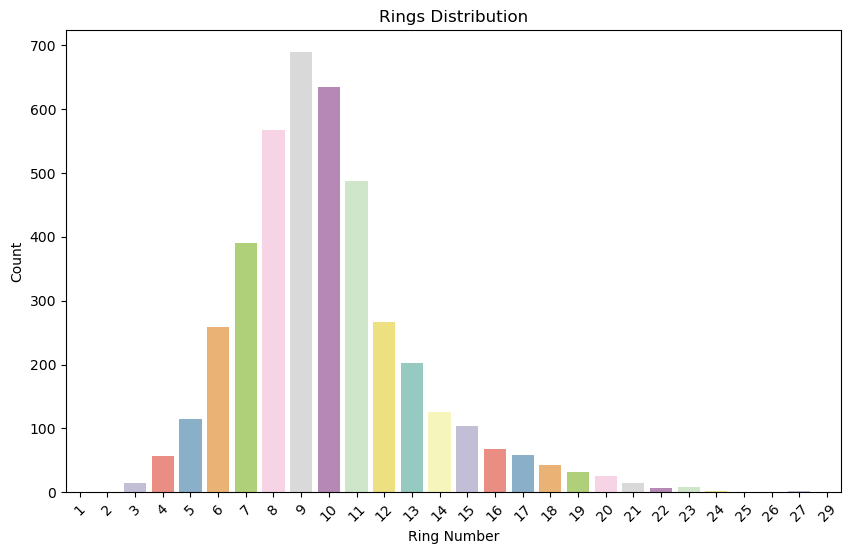

In [42]:
# Visualize Rings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Rings', hue='Rings', palette='Set3', legend=False)
plt.title('Rings Distribution')
plt.xlabel('Ring Number')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [43]:
# Data Preproccesing
from sklearn.preprocessing import LabelEncoder

sex_encoder = LabelEncoder()
rings_encoder = LabelEncoder()

df['Sex'] = sex_encoder.fit_transform(df['Sex'])
df['Rings'] = rings_encoder.fit_transform(df['Rings'])
df = df.drop(['id'], axis=1)
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,14
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,6
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,8
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,9
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,6


In [44]:
# Create Target
x = df.drop(['Rings'], axis=1)
y = df['Rings']

In [49]:
# Train-Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [46]:
# Import Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert to PyTorch Tensors
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Dataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [47]:
# NeuralNetwork Class 
class NeuralNetwork(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(n_hidden, n_hidden)
        self.l3 = nn.Linear(n_hidden, n_output)


    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        return x

# Hyperparameters
n_input = x_train.shape[1]   
n_output = y_train.shape[0]                
n_hidden = 64                

# Functions
model = NeuralNetwork(n_input, n_output, n_hidden).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train Function
def train(dataloader, model, loss_fn, optimizer):
    model.train() 
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test Function
def test(dataloader, model, loss_fn):
    model.eval()  
    test_loss, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Store predictions and true labels for later analysis
            all_preds.append(pred.argmax(1).cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels, test_loss / len(dataloader), correct / len(dataloader.dataset)


# Train + Test Loop
epochs = 20
for t in range(epochs):
    print(f"Epoch [{t+1}/{epochs}] ---------------------------")
    train(train_loader, model, loss_fn, optimizer)
    y_pred, y_true, avg_loss, accuracy = test(test_loader, model, loss_fn)
    print(f"Test Accuracy: {100 * accuracy:.2f}%, Avg loss: {avg_loss:.6f}")

Epoch [1/20] ---------------------------
Test Accuracy: 15.19%, Avg loss: 2.514519
Epoch [2/20] ---------------------------
Test Accuracy: 19.98%, Avg loss: 2.318335
Epoch [3/20] ---------------------------
Test Accuracy: 24.76%, Avg loss: 2.197678
Epoch [4/20] ---------------------------
Test Accuracy: 25.24%, Avg loss: 2.154019
Epoch [5/20] ---------------------------
Test Accuracy: 26.08%, Avg loss: 2.132114
Epoch [6/20] ---------------------------
Test Accuracy: 28.71%, Avg loss: 2.129829
Epoch [7/20] ---------------------------
Test Accuracy: 25.00%, Avg loss: 2.126246
Epoch [8/20] ---------------------------
Test Accuracy: 29.19%, Avg loss: 2.091146
Epoch [9/20] ---------------------------
Test Accuracy: 26.91%, Avg loss: 2.093840
Epoch [10/20] ---------------------------
Test Accuracy: 27.87%, Avg loss: 2.073829
Epoch [11/20] ---------------------------
Test Accuracy: 28.71%, Avg loss: 2.056613
Epoch [12/20] ---------------------------
Test Accuracy: 27.87%, Avg loss: 2.056012
E

Neural Network Classification Report (Original Labels)
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.60      0.27      0.38        11
           5       0.62      0.41      0.49        39
           6       0.47      0.17      0.25        48
           7       0.29      0.68      0.41        78
           8       0.40      0.25      0.31       107
           9       0.30      0.26      0.28       140
          10       0.24      0.69      0.36       127
          11       0.21      0.07      0.11        99
          12       0.00      0.00      0.00        57
          13       0.00      0.00      0.00        38
          14       0.20      0.04      0.07        24
          15       0.00      0.00      0.00        21
          16       0.00      0.00      0.00        10
          17       0.22      0.20      0.21        10
          18       0.00      0.00      0.00         9
          19       0.00   

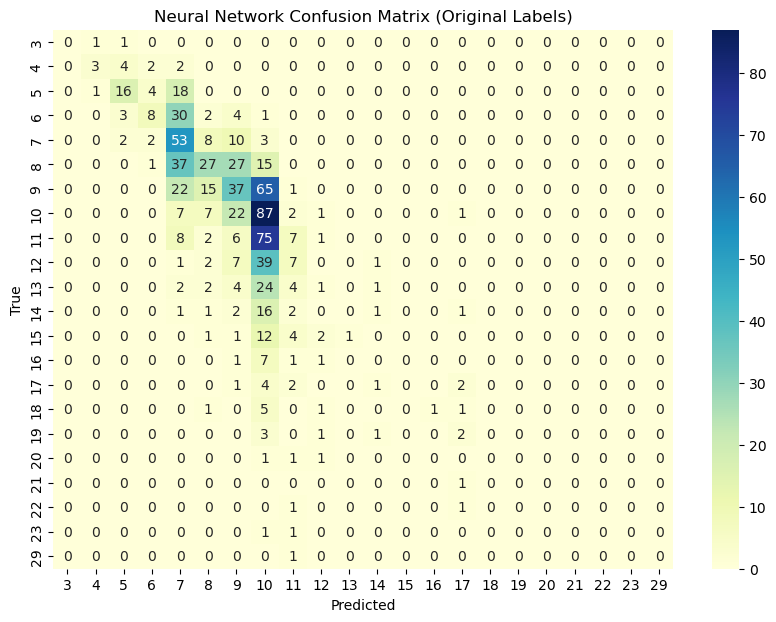

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

# Inverse Encoding
y_true_original = rings_encoder.inverse_transform(y_true)
y_pred_original = rings_encoder.inverse_transform(y_pred)

# Classification Report and Confusion Matrix 
print("Neural Network Classification Report (Original Labels)")
print(classification_report(y_true_original, y_pred_original, zero_division=0))

cm_original = confusion_matrix(y_true_original, y_pred_original)
unique_labels_original = sorted(set(y_true_original) | set(y_pred_original))

plt.figure(figsize=(10, 7))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=unique_labels_original, yticklabels=unique_labels_original)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix (Original Labels)')
plt.show()